In [1]:
import cv2
import numpy as np
import scipy
from scipy.misc import imread
import pickle
import random
import os
import matplotlib.pyplot as plt
import imageio

In [2]:
# Feature extractor
def extract_features(image_path, vector_size=32):
    image = imageio.imread(image_path, pilmode="RGB")
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        cv2.drawKeypoints(image,kps,image, color=(0,255,0), flags=0)
        plt.imshow(image),plt.show()
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print( 'Error: ', e)
        return None

    return dsc


def batch_extractor(images_path, pickled_db_path="features.pck"):
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]

    result = {}
    for f in files:
        print ('Extracting features from image %s' % f)
        name = f.split('/')[-1].lower()
        result[name] = extract_features(f)
    
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)

In [3]:
class Matcher(object):

    def __init__(self, pickled_db_path="features.pck"):
        with open(pickled_db_path, 'rb') as fp:
            self.data = pickle.load(fp)
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()

Extracting features from image image-comparison/images2/0.jpeg


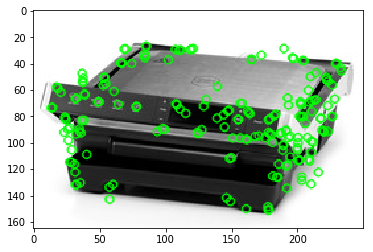

Extracting features from image image-comparison/images2/1.jpeg


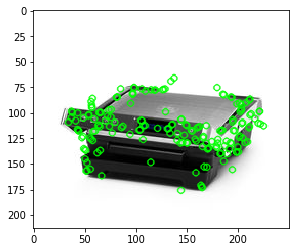

Extracting features from image image-comparison/images2/10.jpeg


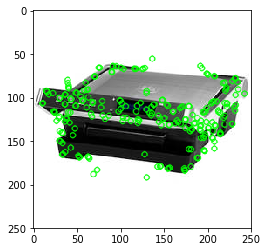

Extracting features from image image-comparison/images2/11.jpeg


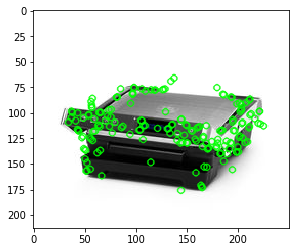

Extracting features from image image-comparison/images2/12.png


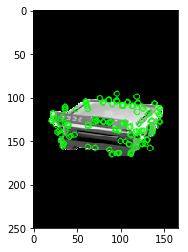

Extracting features from image image-comparison/images2/13.jpeg


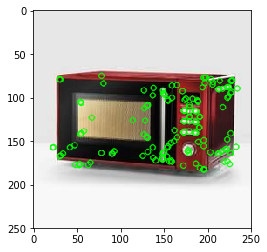

Extracting features from image image-comparison/images2/2.jpeg


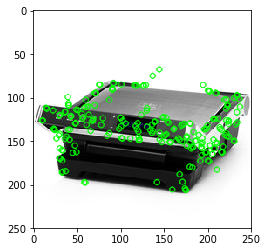

Extracting features from image image-comparison/images2/3.jpeg


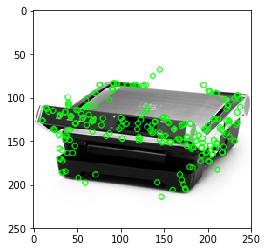

Extracting features from image image-comparison/images2/4.jpeg


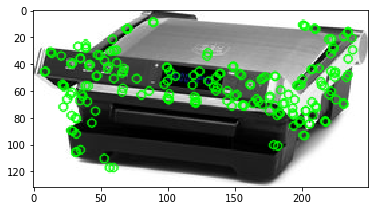

Extracting features from image image-comparison/images2/5.jpeg


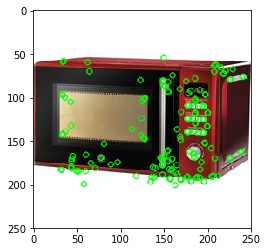

Extracting features from image image-comparison/images2/6.jpeg


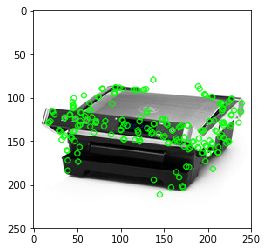

Extracting features from image image-comparison/images2/7.jpeg


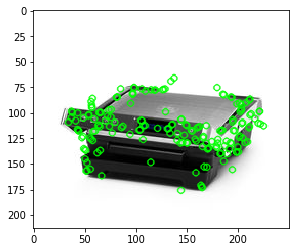

Extracting features from image image-comparison/images2/8.jpeg


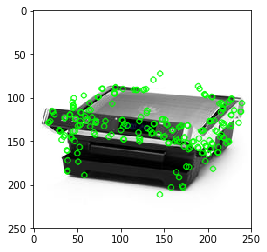

Extracting features from image image-comparison/images2/9.jpeg


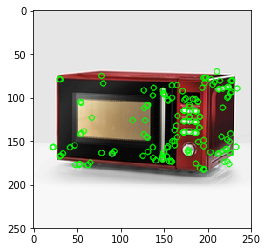

Extracting features from image image-comparison/images2/bed1.jpg


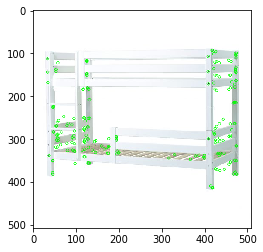

Extracting features from image image-comparison/images2/bed2.jpg


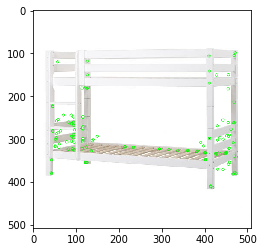

Query image ==========================================


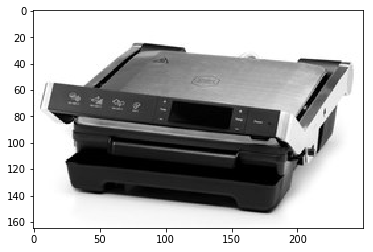

image-comparison/images2/0.jpeg


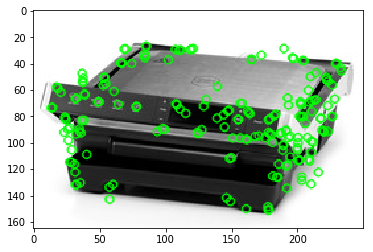

Result images ========================================
Match 0.9999999999999999
0.jpeg


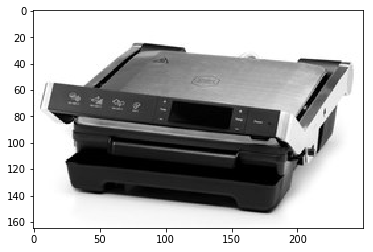

Match 0.7227369675555517
1.jpeg


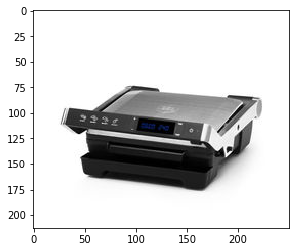

Match 0.7227369675555517
11.jpeg


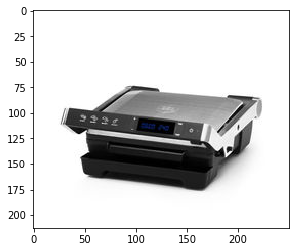

Match 0.7227369675555517
7.jpeg


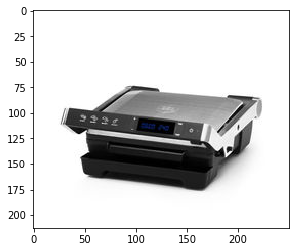

Match 0.719523125369409
8.jpeg


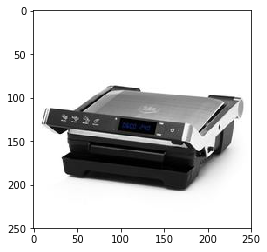

Match 0.7180879900904832
6.jpeg


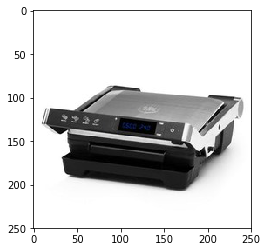

Match 0.6785900767827819
10.jpeg


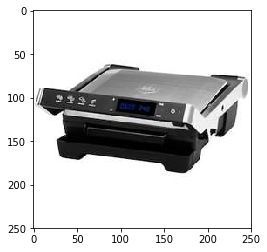

Match 0.6630331910509524
9.jpeg


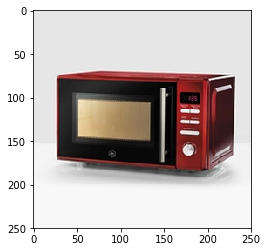

Match 0.6484397976768843
3.jpeg


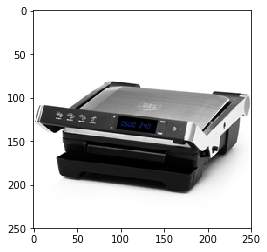

Match 0.6418810450608168
bed2.jpg


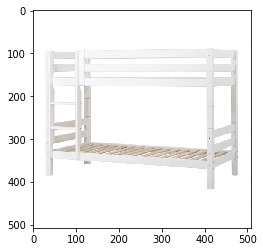

Match 0.6418769421488135
bed1.jpg


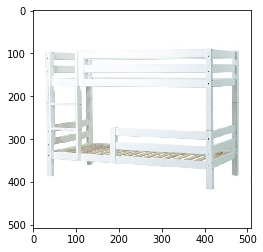

Match 0.6418445824932089
2.jpeg


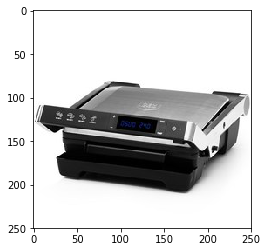

Match 0.6411967473985558
13.jpeg


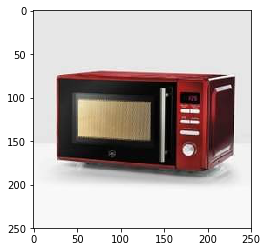

Match 0.621616852476146
5.jpeg


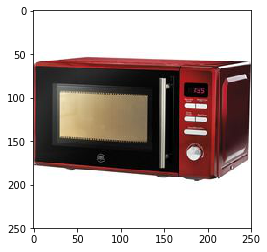

Extracting features from image image-comparison/images/0.jpeg


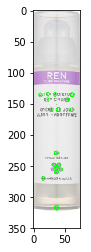

Extracting features from image image-comparison/images/1.jpeg


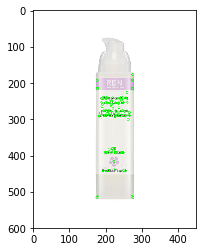

Extracting features from image image-comparison/images/10.jpeg


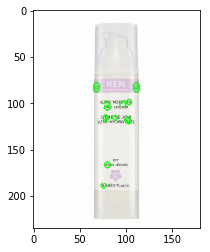

Extracting features from image image-comparison/images/11.jpeg


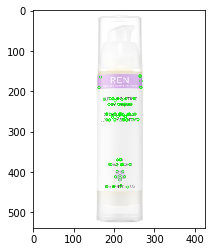

Extracting features from image image-comparison/images/12.jpeg


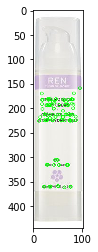

Extracting features from image image-comparison/images/13.jpeg


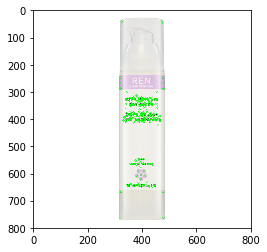

Extracting features from image image-comparison/images/14.jpeg


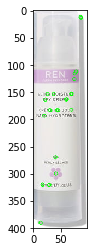

Extracting features from image image-comparison/images/15.jpeg


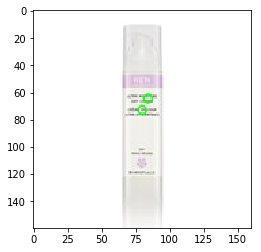

Extracting features from image image-comparison/images/16.jpeg


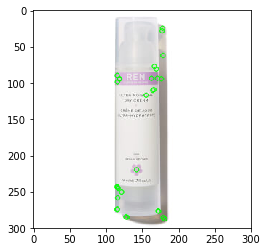

Extracting features from image image-comparison/images/2.jpeg


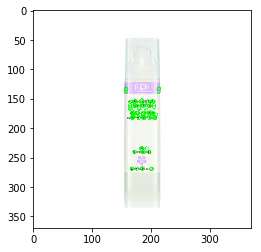

Extracting features from image image-comparison/images/3.jpeg


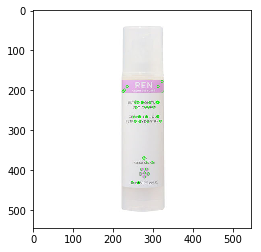

Extracting features from image image-comparison/images/4.jpeg


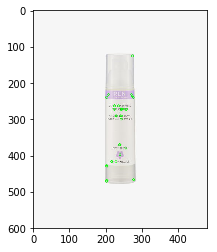

Extracting features from image image-comparison/images/5.jpeg


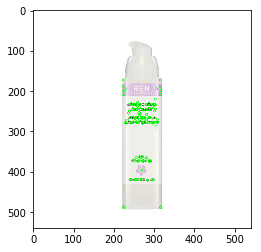

Extracting features from image image-comparison/images/6.jpeg


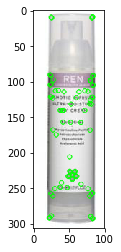

Extracting features from image image-comparison/images/9.jpeg


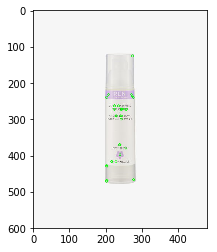

Extracting features from image image-comparison/images/bed1.jpeg


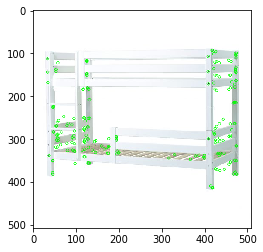

Extracting features from image image-comparison/images/bed2.jpeg


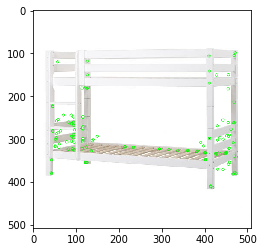

Query image ==========================================


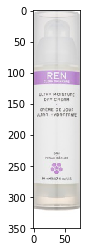

image-comparison/images/0.jpeg


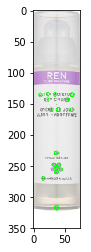

Result images ========================================
Match 0.9999999999999999
0.jpeg


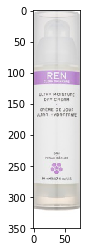

Match 0.6744572370157776
13.jpeg


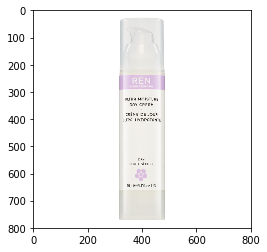

Match 0.6667084541534231
5.jpeg


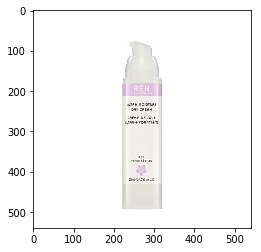

Match 0.6657966065879333
1.jpeg


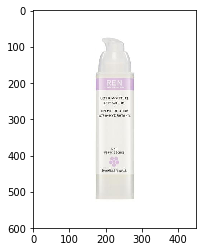

Match 0.6650212900591237
9.jpeg


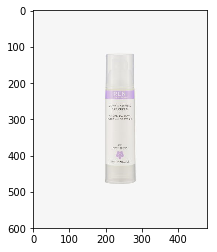

Match 0.6650212900591237
4.jpeg


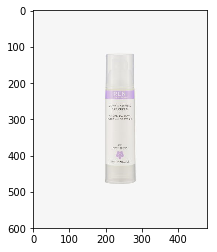

Match 0.6596159834692138
14.jpeg


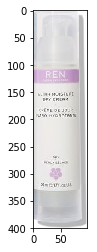

Match 0.6551487912595584
2.jpeg


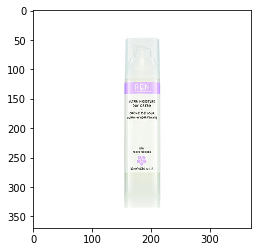

Match 0.6533689323057398
11.jpeg


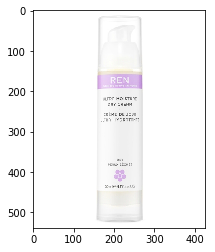

Match 0.6521505311005868
16.jpeg


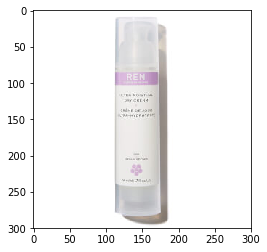

Match 0.6500732202346527
bed2.jpeg


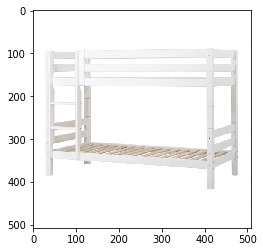

Match 0.648807233630816
bed1.jpeg


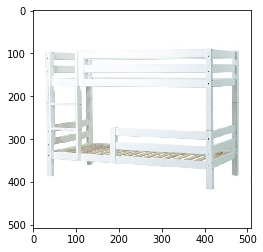

Match 0.6249929461056332
3.jpeg


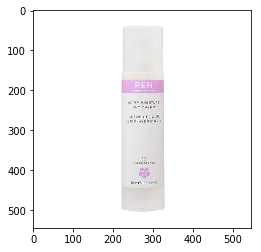

Match 0.6234676336077243
6.jpeg


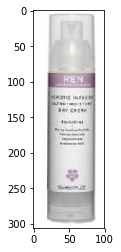

In [9]:
def show_img(path):
    img = imageio.imread(path, pilmode="RGB")
    plt.imshow(img)
    plt.show()
    
def run():
    # images_path = 'resources/images/'
    images_path = 'images2/'
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    sample = [files[0]]
    
    batch_extractor(images_path)

    ma = Matcher('features.pck')
    
    for s in sample:
        print( 'Query image ==========================================')
        show_img(s)
        print(s)
        names, match = ma.match(s, topn=18)
        print ('Result images ========================================')
        for i in range(14):
            # we got cosine distance, less cosine distance between vectors
            # more they similar, thus we subtruct it from 1 to get match value
            print( 'Match %s' % (1-match[i]))
            print(names[i])
            show_img(os.path.join(images_path, names[i]))
            print ('========================================')
           
        
    images_path = 'images/'
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    sample = [files[0]]
    
    batch_extractor(images_path)

    ma = Matcher('features.pck')
    
    for s in sample:
        print( 'Query image ==========================================')
        show_img(s)
        print(s)
        names, match = ma.match(s, topn=18)
        print ('Result images ========================================')
        for i in range(14):
            # we got cosine distance, less cosine distance between vectors
            # more they similar, thus we subtruct it from 1 to get match value
            print( 'Match %s' % (1-match[i]))
            print(names[i])
            show_img(os.path.join(images_path, names[i]))
            print ('========================================')

run()